### <font color='blue'> DAC to audio 
</font>

This notebook reads a DAC file and uses the descript 44.1kHz pretrained DAC to decompress it to audio.   
It is in a separate file from the transformer generative code because it takes up too much memory (which doesn't seem right).  

In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import time

# and for creating a custom dataset and loader:
from torch.utils.data import Dataset, DataLoader
import os
import dac

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd

In [144]:
#import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image

In [145]:
import gc 
# Function to find all tensors on CUDA
def get_cuda_tensors():
    cuda_tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                cuda_tensors.append((type(obj), obj.size()))
        except Exception as e:
            pass
    return cuda_tensors

### <font color='blue'> Parameters 
</font>

In [146]:
# Training data dir

experiment_name="01.20PostNormCond_2_" #"06.30_Keysmall"
cptnum=600 
tstsnd1='bees'  # 'pistons', 'wind', 'applause', 'bees'
tstsnd2= 'wind'
#tstsnd2='bees'

#must match a specific dac file name used
minpval=0
maxpval=1
topn=1024


inference_steps=86*20


SAVEWAV=True
# --------------------------------------------------------------------------

# I am having with running out of memory loading the DAC model with cuda. CPU runs pretty fast
# for decompressing, so there ya go. 
DEVICE='cpu'



In [147]:
if DEVICE == 'cuda' :
    torch.cuda.device_count()
    torch.cuda.get_device_properties(0).total_memory/1e9

    device = torch.device(DEVICE) # if the docker was started with --gpus all, then can choose here with cuda:0 (or cpu)
    torch.cuda.device_count()
    print(f'memeory on cuda 0 is  {torch.cuda.get_device_properties(0).total_memory/1e9}')
else :
    device=DEVICE
device

'cpu'

### <font color='blue'> Get the DAC model 
that will be need *after* we run the transformer in order to reconstruct the signal from codes.
</font>

In [148]:
# The first time you do this, it can take a while. Go get coffee. After that, it uses a cached version
dacmodel_path = dac.utils.download(model_type="44khz") 

with torch.no_grad():
    dacmodel = dac.DAC.load(dacmodel_path)

    dacmodel.to(device); #wanna see the model? remove the semicolon
    dacmodel.eval();  # need to be "in eval mode" in order to set the number of quantizers

### <font color='blue'> Codes-2-Audio reconstruction
that will be need *after* we run the transformer in order to reconstruct the signal from codes.
</font>

 fname is bees.wind_chkpt_0600_steps_1720.minpval_0.00.maxpval_1.00.topn_1024
dacfile.codes shape is: torch.Size([1, 4, 1720])
decompress time for 19.969160997732427 seconds of sound is 8.573607921600342
asig.audio_data.shape[2] is 880640



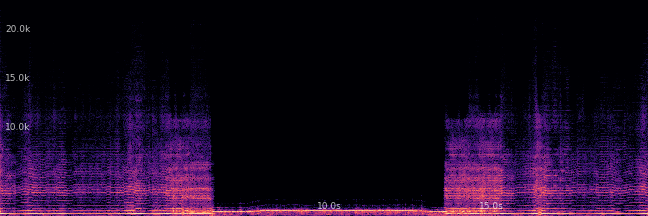
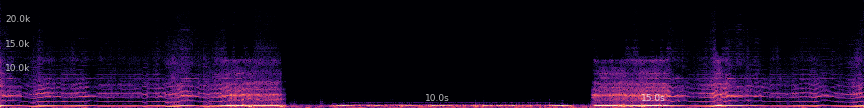

In [149]:
# --------  derived ------ don't change these 
fname=tstsnd1+ '.' + tstsnd2 + '_chkpt_' + str(cptnum).zfill(4) + '_steps_'+str(inference_steps).zfill(4)+'.minpval_'+ f"{minpval:01.2f}" +'.maxpval_'+ f"{maxpval:01.2f}" +'.topn_'+ f"{topn:04d}"
data_dir= 'runs' + '/' + experiment_name
selected_file=data_dir+'/' + "dacs" + '/' + fname + ".dac"
print(f' fname is {fname}')

with torch.no_grad():
    dacfile = dac.DACFile.load(selected_file)
    # FIRST - Decompress it back to an AudioSignal\ from codes to z (1024) to signal   
    print(f'dacfile.codes shape is: {dacfile.codes.shape}')
    t0=time.time()
    asig=dacmodel.decompress(dacfile)
    t1=time.time()
    
    inf_time = t1-t0
    print(f'decompress time for {asig.audio_data.shape[2]/44100} seconds of sound is {inf_time}' )
    print(f'asig.audio_data.shape[2] is {asig.audio_data.shape[2]}')
    
    asig.cpu().widget()
    asig.save_image(data_dir+'/' + "dacs" + '/' + fname + ".jpg")
    asig.audio_data.shape

In [150]:

adata = asig.samples.view(-1).numpy()
if SAVEWAV :  
    sf.write(data_dir+'/' + "dacs" + '/' + fname + ".wav", adata, 44100)


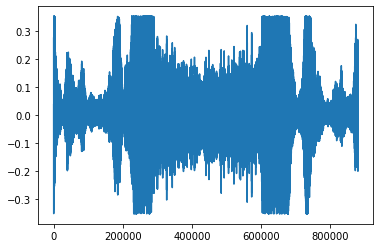

In [151]:
plt.plot(adata)
ipd.Audio(adata, rate=44100)

In [152]:
# This will list every variable on cuda if you are using it. 
cuda_tensors = get_cuda_tensors()
for tensor_type, tensor_size in cuda_tensors:
    print(f'Type: {tensor_type}, Size: {tensor_size}')